combine 0:no expression and 4:random into a single 0:ignore class

at inference time, we don't care about the difference

the class imbalance might also be useful - as this will be our do nothing default - and we only want to take action when we're sure a command is being requested

TODO: 
- save stats with model
- Try bigger batch size - even if it means we need more epochs
- model size/depth
- Exaggerate 0 imbalance - how far do we have to go to not got any 0s misclassified (on test set)
- see what happens if we don't use nose landmarks for training - try with/without normalizing for nose

In [1]:
# run this, then restart the runtime
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 186 kB 5.6 MB/s 
     |████████████████████████████████| 56 kB 1.8 MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from fastai.tabular.all import *
from pathlib import Path
import pandas as pd

In [52]:
dataset_id = '20211014143136'
path = Path('/content/drive/MyDrive/Colab Notebooks/datasets')
df = pd.read_csv(path/f'data_{dataset_id}.csv')

In [53]:
df

,img_path,0x,0y,0z,1x,1y,1z,2x,2y,2z,3x,3y,3z,4x,4y,4z,5x,5y,5z,6x,6y,6z,7x,7y,7z,8x,8y,8z,9x,9y,9z,10x,10y,10z,11x,11y,11z,12x,12y,12z,...,455x,455y,455z,456x,456y,456z,457x,457y,457z,458x,458y,458z,459x,459y,459z,460x,460y,460z,461x,461y,461z,462x,462y,462z,463x,463y,463z,464x,464y,464z,465x,465y,465z,466x,466y,466z,467x,467y,467z,expression_id
0,NaN,0.443007,0.653161,-0.030659,0.440569,0.596945,-0.059487,0.441614,0.613038,-0.030596,0.429970,0.538499,-0.044958,0.440055,0.579264,-0.063510,0.439566,0.555355,-0.059289,0.438866,0.497127,-0.029783,0.358153,0.495353,0.015941,0.437793,0.452476,-0.022545,0.437282,0.428671,-0.025340,0.434842,0.345631,-0.014160,0.443319,0.661441,-0.029059,0.443629,0.667363,-0.025009,...,0.472067,0.599223,-0.026632,0.458205,0.544964,-0.037651,0.457650,0.592700,-0.053347,0.451825,0.600709,-0.048622,0.457647,0.595006,-0.047869,0.468939,0.604326,-0.022744,0.449909,0.602739,-0.051461,0.448906,0.605724,-0.038103,0.468653,0.491456,0.005935,0.462041,0.495701,-0.000759,0.458547,0.498621,-0.008422,0.522647,0.479407,0.011814,0.528239,0.473191,0.012033,0
1,NaN,0.443189,0.655738,-0.031247,0.440646,0.599650,-0.059695,0.441752,0.615588,-0.031114,0.429611,0.540135,-0.044587,0.440012,0.581673,-0.063596,0.439365,0.557283,-0.059202,0.438291,0.497893,-0.029076,0.358150,0.498097,0.017572,0.436763,0.452403,-0.021357,0.435961,0.428233,-0.023739,0.433033,0.346585,-0.011696,0.443528,0.664124,-0.029629,0.443951,0.670157,-0.025618,...,0.473153,0.601072,-0.027241,0.458088,0.546347,-0.037659,0.458126,0.595209,-0.053711,0.452313,0.603309,-0.049030,0.458180,0.597481,-0.048253,0.470057,0.606208,-0.023349,0.450299,0.605421,-0.051859,0.449413,0.608349,-0.038590,0.468098,0.492006,0.006338,0.461520,0.496290,-0.000254,0.458023,0.499269,-0.007914,0.521560,0.480550,0.011677,0.527155,0.473593,0.011928,0
2,NaN,0.442790,0.665560,-0.030301,0.440620,0.613159,-0.059110,0.441407,0.628036,-0.030891,0.429207,0.553466,-0.044622,0.440068,0.595280,-0.063018,0.439306,0.570778,-0.058906,0.437931,0.511416,-0.029510,0.356610,0.512289,0.016511,0.436208,0.464427,-0.022116,0.435479,0.439860,-0.024536,0.433295,0.360391,-0.013598,0.443076,0.673639,-0.028509,0.443418,0.679575,-0.024398,...,0.473927,0.613449,-0.027132,0.458109,0.559667,-0.037787,0.458578,0.608948,-0.053260,0.452613,0.616847,-0.048570,0.458642,0.611190,-0.047892,0.470704,0.618265,-0.023277,0.450517,0.618939,-0.051361,0.449558,0.621578,-0.038271,0.467697,0.506039,0.005113,0.461204,0.509921,-0.001362,0.457753,0.512797,-0.008695,0.520404,0.498539,0.010137,0.526428,0.489315,0.010700,0
3,NaN,0.443790,0.695196,-0.025137,0.443546,0.647275,-0.058448,0.443296,0.658936,-0.028346,0.433294,0.583347,-0.047764,0.443560,0.629503,-0.063299,0.443296,0.603400,-0.060574,0.442558,0.537432,-0.035143,0.359974,0.527454,0.008429,0.441826,0.488120,-0.030473,0.441670,0.463471,-0.034508,0.441276,0.378324,-0.029601,0.443870,0.703104,-0.022843,0.443970,0.708448,-0.018370,...,0.476026,0.642778,-0.024917,0.461599,0.589096,-0.039406,0.461578,0.642309,-0.052342,0.455364,0.649319,-0.047153,0.461461,0.643727,-0.046750,0.472770,0.647214,-0.020798,0.453223,0.651859,-0.049968,0.452072,0.653477,-0.036318,0.471291,0.526239,0.000708,0.464909,0.531260,-0.005869,0.461669,0.535586,-0.013218,0.524360,0.517589,0.006797,0.530097,0.508854,0.007240,0
4,NaN,0.447181,0.697193,-0.023318,0.446876,0.647848,-0.058081,0.446443,0.659002,-0.027473,0.435711,0.583822,-0.048268,0.446671,0.630287,-0.063157,0.445970,0.604151,-0.060685,0.444229,0.537241,-0.036424,0.361714,0.526156,0.006745,0.442795,0.488171,-0.032401,0.442321,0.463758,-0.036835,0.440399,0.377039,-0.033447,0.447311,0.705025,-0.020942,0.447412,0.710126,-0.016561,...,0.478526,0.641652,-0.024488,0.463899,0.588885,-0.039855,0.464587,0.642188,-0.052059,0.458524,0.649122,-0.046684,0.464526,0.643292,-0.046410,0.475293,0.646150,-0.020190,0.456435,0.651830,-0.049461,0.455224,0.653198,-0.035686,0.472048,0.524047,-0.000647,0.465936,0.529569,-0.007136,0.462931,0.534237,-0.014469,0.525256,0.512154,0.005282

In [54]:
# make all x and y values relative to tip of nose
for i in range(468):
    df[f'{i}x']=df[f'{i}x']-df['1x']
    df[f'{i}y']=df[f'{i}y']-df['1y']

In [55]:
df

,img_path,0x,0y,0z,1x,1y,1z,2x,2y,2z,3x,3y,3z,4x,4y,4z,5x,5y,5z,6x,6y,6z,7x,7y,7z,8x,8y,8z,9x,9y,9z,10x,10y,10z,11x,11y,11z,12x,12y,12z,...,455x,455y,455z,456x,456y,456z,457x,457y,457z,458x,458y,458z,459x,459y,459z,460x,460y,460z,461x,461y,461z,462x,462y,462z,463x,463y,463z,464x,464y,464z,465x,465y,465z,466x,466y,466z,467x,467y,467z,expression_id
0,NaN,0.002438,0.056215,-0.030659,0.0,0.0,-0.059487,0.441614,0.613038,-0.030596,0.429970,0.538499,-0.044958,0.440055,0.579264,-0.063510,0.439566,0.555355,-0.059289,0.438866,0.497127,-0.029783,0.358153,0.495353,0.015941,0.437793,0.452476,-0.022545,0.437282,0.428671,-0.025340,0.434842,0.345631,-0.014160,0.443319,0.661441,-0.029059,0.443629,0.667363,-0.025009,...,0.472067,0.599223,-0.026632,0.458205,0.544964,-0.037651,0.457650,0.592700,-0.053347,0.451825,0.600709,-0.048622,0.457647,0.595006,-0.047869,0.468939,0.604326,-0.022744,0.449909,0.602739,-0.051461,0.448906,0.605724,-0.038103,0.468653,0.491456,0.005935,0.462041,0.495701,-0.000759,0.458547,0.498621,-0.008422,0.522647,0.479407,0.011814,0.528239,0.473191,0.012033,0
1,NaN,0.002543,0.056087,-0.031247,0.0,0.0,-0.059695,0.441752,0.615588,-0.031114,0.429611,0.540135,-0.044587,0.440012,0.581673,-0.063596,0.439365,0.557283,-0.059202,0.438291,0.497893,-0.029076,0.358150,0.498097,0.017572,0.436763,0.452403,-0.021357,0.435961,0.428233,-0.023739,0.433033,0.346585,-0.011696,0.443528,0.664124,-0.029629,0.443951,0.670157,-0.025618,...,0.473153,0.601072,-0.027241,0.458088,0.546347,-0.037659,0.458126,0.595209,-0.053711,0.452313,0.603309,-0.049030,0.458180,0.597481,-0.048253,0.470057,0.606208,-0.023349,0.450299,0.605421,-0.051859,0.449413,0.608349,-0.038590,0.468098,0.492006,0.006338,0.461520,0.496290,-0.000254,0.458023,0.499269,-0.007914,0.521560,0.480550,0.011677,0.527155,0.473593,0.011928,0
2,NaN,0.002170,0.052400,-0.030301,0.0,0.0,-0.059110,0.441407,0.628036,-0.030891,0.429207,0.553466,-0.044622,0.440068,0.595280,-0.063018,0.439306,0.570778,-0.058906,0.437931,0.511416,-0.029510,0.356610,0.512289,0.016511,0.436208,0.464427,-0.022116,0.435479,0.439860,-0.024536,0.433295,0.360391,-0.013598,0.443076,0.673639,-0.028509,0.443418,0.679575,-0.024398,...,0.473927,0.613449,-0.027132,0.458109,0.559667,-0.037787,0.458578,0.608948,-0.053260,0.452613,0.616847,-0.048570,0.458642,0.611190,-0.047892,0.470704,0.618265,-0.023277,0.450517,0.618939,-0.051361,0.449558,0.621578,-0.038271,0.467697,0.506039,0.005113,0.461204,0.509921,-0.001362,0.457753,0.512797,-0.008695,0.520404,0.498539,0.010137,0.526428,0.489315,0.010700,0
3,NaN,0.000244,0.047920,-0.025137,0.0,0.0,-0.058448,0.443296,0.658936,-0.028346,0.433294,0.583347,-0.047764,0.443560,0.629503,-0.063299,0.443296,0.603400,-0.060574,0.442558,0.537432,-0.035143,0.359974,0.527454,0.008429,0.441826,0.488120,-0.030473,0.441670,0.463471,-0.034508,0.441276,0.378324,-0.029601,0.443870,0.703104,-0.022843,0.443970,0.708448,-0.018370,...,0.476026,0.642778,-0.024917,0.461599,0.589096,-0.039406,0.461578,0.642309,-0.052342,0.455364,0.649319,-0.047153,0.461461,0.643727,-0.046750,0.472770,0.647214,-0.020798,0.453223,0.651859,-0.049968,0.452072,0.653477,-0.036318,0.471291,0.526239,0.000708,0.464909,0.531260,-0.005869,0.461669,0.535586,-0.013218,0.524360,0.517589,0.006797,0.530097,0.508854,0.007240,0
4,NaN,0.000305,0.049346,-0.023318,0.0,0.0,-0.058081,0.446443,0.659002,-0.027473,0.435711,0.583822,-0.048268,0.446671,0.630287,-0.063157,0.445970,0.604151,-0.060685,0.444229,0.537241,-0.036424,0.361714,0.526156,0.006745,0.442795,0.488171,-0.032401,0.442321,0.463758,-0.036835,0.440399,0.377039,-0.033447,0.447311,0.705025,-0.020942,0.447412,0.710126,-0.016561,...,0.478526,0.641652,-0.024488,0.463899,0.588885,-0.039855,0.464587,0.642188,-0.052059,0.458524,0.649122,-0.046684,0.464526,0.643292,-0.046410,0.475293,0.646150,-0.020190,0.456435,0.651830,-0.049461,0.455224,0.653198,-0.035686,0.472048,0.524047,-0.000647,0.465936,0.529569,-0.007136,0.462931,0.534237,-0.014469,0.525256,0.512154,0.005282,0.530778,0.504607,0.005459,0
...,...,...,...,...,

In [56]:
# calculate stats for normalization
stats = {}
for i in range(468):
    for coord in ['x','y','z']: 
        col=f'{i}{coord}'
        stats[col]={}
        stats[col]['mean']=df[col].mean()
        stats[col]['std']=df[col].std()

In [57]:
# save these stats so we can use them at inference time
import json
with open(path/f'stats_data_{dataset_id}.json', 'w') as f:
    json.dump(stats, f)

In [58]:
# normalize
for i in range(468):
    if i == 1: continue # it's all zeros
    for coord in ['x','y','z']:
        col=f'{i}{coord}'
        df[col]=df[col]-stats[col]['mean']
        df[col]=df[col]/stats[col]['std']

In [59]:
df

,img_path,0x,0y,0z,1x,1y,1z,2x,2y,2z,3x,3y,3z,4x,4y,4z,5x,5y,5z,6x,6y,6z,7x,7y,7z,8x,8y,8z,9x,9y,9z,10x,10y,10z,11x,11y,11z,12x,12y,12z,...,455x,455y,455z,456x,456y,456z,457x,457y,457z,458x,458y,458z,459x,459y,459z,460x,460y,460z,461x,461y,461z,462x,462y,462z,463x,463y,463z,464x,464y,464z,465x,465y,465z,466x,466y,466z,467x,467y,467z,expression_id
0,NaN,-0.034922,-1.144282,1.247061,0.0,0.0,-0.059487,-0.290295,1.111212,1.360473,-0.269436,1.238497,-0.207675,-0.261574,1.168478,0.520406,-0.267542,1.210344,0.131738,-0.291722,1.323504,-0.671683,-0.312267,1.262642,-0.435192,-0.299998,1.429369,-0.834608,-0.294927,1.463271,-0.875733,-0.306962,1.506396,-0.934491,-0.296655,1.004835,1.215771,-0.302754,0.972410,1.197331,...,-0.344967,1.177815,0.664157,-0.305088,1.248109,-0.086188,-0.292290,1.152598,0.712624,-0.293461,1.131325,0.993972,-0.300311,1.149251,0.763651,-0.347922,1.162713,0.784169,-0.286520,1.127701,1.022474,-0.295567,1.120671,1.232791,-0.362380,1.405506,-0.671794,-0.353188,1.382140,-0.710961,-0.338650,1.358950,-0.700030,-0.397506,1.305635,-0.363628,-0.421346,1.393531,-0.370220,0
1,NaN,-0.015932,-1.169372,1.140568,0.0,0.0,-0.059695,-0.287766,1.194034,1.196429,-0.275821,1.292921,-0.133480,-0.262291,1.240248,0.499305,-0.270993,1.270447,0.151336,-0.302384,1.351755,-0.565898,-0.312332,1.391507,-0.321491,-0.319470,1.426551,-0.708801,-0.319688,1.446419,-0.735779,-0.341406,1.548995,-0.796208,-0.292759,1.089932,1.121418,-0.296635,1.062578,1.103115,...,-0.324440,1.240428,0.540109,-0.307217,1.295287,-0.087921,-0.284015,1.229284,0.622224,-0.284813,1.212508,0.874495,-0.290878,1.226434,0.664162,-0.326565,1.227217,0.647211,-0.279689,1.210352,0.907856,-0.286486,1.203992,1.072886,-0.373977,1.429217,-0.619358,-0.363876,1.406895,-0.636792,-0.349120,1.385197,-0.621072,-0.421442,1.359321,-0.373347,-0.445453,1.411725,-0.377226,0
2,NaN,-0.083636,-1.893304,1.311996,0.0,0.0,-0.059110,-0.294080,1.598186,1.266994,-0.283003,1.736222,-0.140467,-0.261357,1.645517,0.641182,-0.271986,1.691073,0.217753,-0.309038,1.850794,-0.630747,-0.346649,2.057971,-0.395414,-0.329960,1.890991,-0.789223,-0.328735,1.894402,-0.805423,-0.336415,2.165434,-0.902936,-0.301195,1.391814,1.306674,-0.306751,1.366508,1.291867,...,-0.309796,1.659558,0.562166,-0.306845,1.749830,-0.115415,-0.276133,1.649160,0.734118,-0.279490,1.635276,1.009259,-0.282677,1.653885,0.757541,-0.314218,1.640612,0.663641,-0.275862,1.626993,1.051509,-0.283881,1.623960,1.177694,-0.382380,2.034012,-0.778709,-0.370351,1.979697,-0.799373,-0.354515,1.933560,-0.742459,-0.446883,2.203644,-0.482231,-0.461616,2.123237,-0.458738,0
3,NaN,-0.433419,-2.772841,2.248305,0.0,0.0,-0.058448,-0.259513,2.601452,2.073586,-0.210346,2.729927,-0.768568,-0.202766,2.664805,0.572257,-0.203781,2.707873,-0.156556,-0.223360,2.810812,-1.473329,-0.271728,2.770148,-0.958704,-0.223744,2.806168,-1.674443,-0.212633,2.804141,-1.677676,-0.184430,2.966138,-1.801271,-0.286374,2.326582,2.243319,-0.296287,2.298287,2.224900,...,-0.270110,2.652712,1.013409,-0.243248,2.754137,-0.462122,-0.223919,2.668701,0.961676,-0.230732,2.649289,1.424692,-0.232729,2.668353,1.053518,-0.274750,2.633158,1.224752,-0.228406,2.641672,1.452716,-0.238822,2.636670,1.819156,-0.307178,2.904605,-1.351401,-0.294373,2.876422,-1.460098,-0.276297,2.857246,-1.445128,-0.359813,3.097829,-0.718363,-0.380026,3.007512,-0.688371,0
4,NaN,-0.422362,-2.493014,2.578099,0.0,0.0,-0.058081,-0.201950,2.603593,2.350142,-0.167380,2.745715,-0.869264,-0.150586,2.688152,0.607031,-0.158049,2.731306,-0.181300,-0.192401,2.803756,-1.665009,-0.232962,2.709195,-1.076124,-0.205434,2.808129,-1.878689,-0.200408,2.815203,-1.881184,-0.201140,2.908742,-2.017134,-0.222098,2.387520,2.557570,-0.230930,2.352431,2.504959,...,-0.222854,2.614576,1.100859,-0.201332,2.746945,-0.558337,-0.171546,2.665012,1.031983,-0.174731,2.643152,1.562302,-0.178407,2.654800,1.141624,-0.226555,2.596680,1.362255,-0.172077,2.640781,1.598741,-0.182331,2.627799,2.026856,-0.291343,2.810146,-1.527558,-0.273318,2.805383,-1.645958,-0.251106,2.802577,-1.6

In [62]:
df['expression_id'].value_counts()

0    4000
3    2000
2    2000
1    2000
Name: expression_id, dtype: int64

In [61]:
# combine 0:no expression and 4:random into a single 0:ignore class
df.loc[df['expression_id']==4, 'expression_id']=0

In [63]:
face_point_ids = [5, 2, 218, 438] # up,down,left,right - no point having 1 tip_of_nose as it's always 0
mouth_landmarks = [0, 11, 12, 13, 14, 15, 16, 17, 18, 37, 38, 39, 40, 41, 42, 43, 57, 61, 62, 72, 73, 74, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 106, 146, 164, 165, 167, 178, 179, 180, 181, 182, 183, 184, 185, 186, 191, 204, 267, 268, 269, 270, 271, 272, 273, 287, 291, 292, 302, 303, 304, 306, 307, 308, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 324, 325, 335, 375, 391, 393, 402, 403, 404, 405, 406, 407, 408, 409, 410, 415, 424]

In [64]:
cont_names = []
for i in face_point_ids+mouth_landmarks:
# for i in range(468):
    cont_names.append(f'{i}x')
    cont_names.append(f'{i}y')
cat_names = []
procs = []

In [65]:
len(face_point_ids+mouth_landmarks)

106

In [66]:
# splits = RandomSplitter(valid_pct=0.2)(range_of(df))
# to = TabularPandas(df, procs=procs,
#                    cat_names = cat_names,
#                    cont_names = cont_names,
#                    y_names='expression_id',
#                    splits=splits)
# dls = to.dataloaders(bs=64)

In [67]:
# dls.show_batch()

In [68]:
dls = TabularDataLoaders.from_df(df, path, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                                 y_names="expression_id", y_block=CategoryBlock,
                                 valid_idx=list(range(0, len(df), 10)), bs=256)
learn = tabular_learner(dls, metrics=accuracy)

SuggestedLRs(valley=0.0006918309954926372)

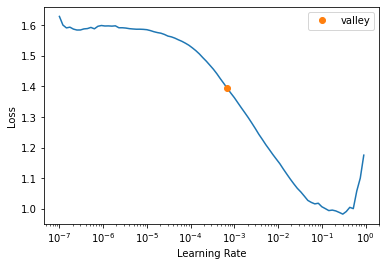

In [69]:
learn.lr_find()

In [70]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

```
bs 64
25, 8e-4 -> 97.4 + wd=1e-2 -> 97.7
bs 256
25, 8e-4, wd=1e-2 -> 98.4
bs 1024
35, 8e-4, wd=1e-2 -> 97.7
```

In [71]:
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(25, 8e-4, wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.107800,1.118877,0.616000,00:00
1,0.853986,0.638906,0.811000,00:00
2,0.611796,0.353706,0.909000,00:00
3,0.433860,0.295958,0.911000,00:00
4,0.336358,0.226945,0.950000,00:00
5,0.286976,0.191015,0.943000,00:00
6,0.229817,0.184776,0.937000,00:00
7,0.206963,0.175097,0.943000,00:00
8,0.184886,0.158870,0.944000,00:00
9,0.170753,0.184032,0.932000,00:00


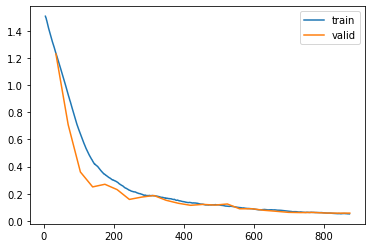

In [31]:
learn.recorder.plot_loss()

In [72]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(212, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=212, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=4, bias=True)
    )
  )
)

In [73]:
import pickle
class NpModelHelper:
    def __init__(self, path, model_id):
        self.model_id, self.path = model_id, path/f'model_{model_id}.pkl'
    def set_state(self, model):
        self.state_dict, state_dict = {}, learn.model.state_dict()
        for k in state_dict:
            self.state_dict[k] = state_dict[k].detach().cpu().numpy()
        return self
    def save(self):
        # can't set allow_pickle=False with np.savez https://github.com/numpy/numpy/issues/13983
        # so we might as well pickle and keep the dict order
        # TODO: don't need the dict order any more - go back to npz
        with open(self.path, 'wb') as f:
            pickle.dump(self.state_dict, f)
        return self
    def load(self):
        with open(self.path, 'rb') as f:
            self.state_dict = pickle.load(f)
        return self
    def get_state_dict(self, name_prefix):
        if name_prefix is None or name_prefix == '': 
            return self.state_dict
        return {k[len(name_prefix)+1:]:self.state_dict[k] 
                for k in self.state_dict 
                if k.startswith(name_prefix)}

In [74]:
np_model_helper = NpModelHelper(path, dataset_id)
np_model_helper.set_state(learn.model).save()

In [75]:
np_model_helper = NpModelHelper(path, dataset_id).load()

In [76]:
class NpBatchNorm1d:
    # https://github.com/pytorch/pytorch/blob/420b37f3c67950ed93cd8aa7a12e673fcfc5567b/aten/src/ATen/native/Normalization.cpp#L61-L126
    def __init__(self, weight, bias, running_mean, running_var, num_batches_tracked=None):
        self.weight, self.bias = weight, bias
        self.running_mean, self.running_std = running_mean, np.sqrt(running_var + 1e-5)
    def __call__(self, x):
        x = x - self.running_mean
        x = x / self.running_std
        x = x * self.weight
        x = x + self.bias
        return x

In [77]:
class NpLinear:
    def __init__(self, weight, bias=None):
        self.weight, self.bias = weight.T, bias
    def __call__(self, x):
        x = x @ self.weight
        if self.bias is not None:
            x = x + self.bias
        return x

In [78]:
class NpReLU:
    def __call__(self, x):
        return np.maximum(x, 0)

In [79]:
class NpModel:
    def __init__(self, modules):
        self.modules = modules
    def __call__(self, x):
        for module in self.modules:
            x = module(x)
        return x

In [80]:
np_model = NpModel([
                    NpBatchNorm1d(**np_model_helper.get_state_dict('bn_cont')),
                    NpLinear(**np_model_helper.get_state_dict('layers.0.0')),
                    NpReLU(),
                    NpBatchNorm1d(**np_model_helper.get_state_dict('layers.0.2')),
                    NpLinear(**np_model_helper.get_state_dict('layers.1.0')),
                    NpReLU(),
                    NpBatchNorm1d(**np_model_helper.get_state_dict('layers.1.2')),
                    NpLinear(**np_model_helper.get_state_dict('layers.2.0'))
                   ])

In [81]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(212, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=212, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=4, bias=True)
    )
  )
)

In [82]:
class_id_to_label = {
        0: "No expression",
        1: "oo",
        2: "ee",
        3: "ah",
        4: "Random Talking"
    }

In [83]:
confusion_matrix = np.zeros([5,5], dtype=int) # TODO: don't hard code
output = np_model(df[cont_names].to_numpy())
preds = np.argmax(output, axis=1)
targets = df['expression_id'].to_numpy()
for p,t in zip(preds, targets):
    confusion_matrix[t][p]+=1

In [84]:
confusion_matrix

array([[3946,    9,   28,   17,    0],
       [   9, 1991,    0,    0,    0],
       [   6,    0, 1982,   12,    0],
       [   2,    0,   22, 1976,    0],
       [   0,    0,    0,    0,    0]])

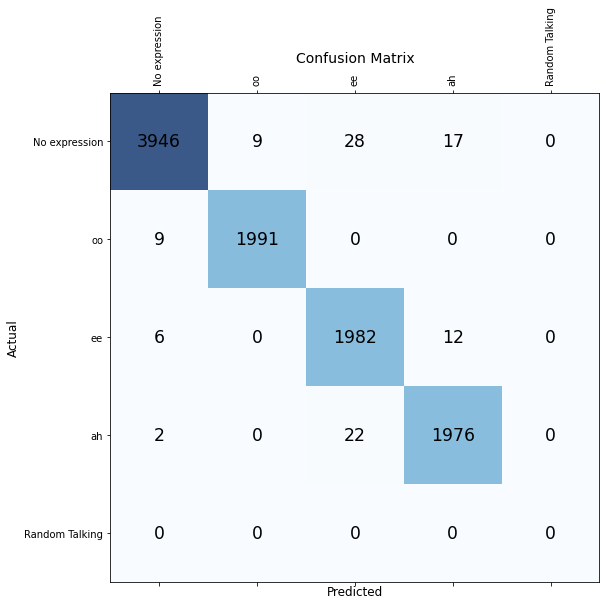

In [85]:
# confusion_matrix = np.array([[0,2,1],[1,2,0],[2,1,0]])
fig, ax = plt.subplots(figsize=(9,9))
ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.8)
# ax.xaxis.set_ticks_position('bottom') # must be after matshow
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
tick_marks = np.arange(5)
# plt.xticks(tick_marks, self.data.y.classes, rotation=90)
plt.xticks(tick_marks, class_id_to_label.values(), rotation=90)
plt.yticks(tick_marks, class_id_to_label.values(), rotation=0)
plt.show()